# Adiabatic switching in Quantum Monte Carlo
The programme computes the free energy for the double well potential $V(x)=\lambda(x^2-\eta^2)^2$ adopting the adiabatic switching method.

Input parameters, with default values:
- potential parameters: $\lambda=1$, $\eta=1.4$
- mass of the particle: $m=0.5$
- number of lattice points to start with: $N=20$
- lattice spacing: $a=0.05$
- number of Metropolis configurations: $N_{sweeps}=100$
- number of sweeps between each measurement: $N_{cor}=50$
- number of iterations $n$ in $N$, with $N(n)=N\cdot 2^n$, starting from $n=0$: $n=6$
- oscillator constant of the reference system: $\omega_0=4\eta=5.6$
- number of steps in adiabatic switching: $N_{switch}=20$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import math
import random
from tqdm.notebook import tqdm

In [2]:
# Parameters of the potential
Lambda = float(input("lambda = ") or 1);
eta = float(input("eta = ") or 1.4);
m = float(input("m = ") or 1/2);
hbar = 1;

lambda = 
eta = 
m = 


In [85]:
# Lattice parameters
N = int(input("N = ") or 20);
a = float(input("a = ") or 0.05);
Nsweeps = int(input("Nsweeps = ") or 100);
Ncor = int(input("Ncorrelation = ") or 50);

N = 
a = 
Nsweeps = 
Ncorrelation = 50


In [4]:
# Additional parameters
n = int(input("n = ") or 6);                  # Number of iterations in N
w0 = float(input("omega0 = ") or 4*eta);      # Oscillator constant of the reference system
Nswitch = int(input("Nswitch = ") or 20);     # Number of steps in adiabatic switching

n = 
omega0 = 
Nswitch = 


In [5]:
eps = float(input("epsilon = ") or 0.1);

# Function that updates x according to Metropolis algorithm
def update(x, alpha, N):
    
    for j in range(N):
        old_x = x[j];                                    # Save the original values
        old_Sj, deltaS = S(j, x, alpha, N);
        x[j] = x[j] + random.gauss(0, eps);              # Update x[j]
        new_Sj, deltaS = S(j, x, alpha, N)
        dS = new_Sj - old_Sj;                            # Change in action
        
        if np.exp(-dS) < random.random():                # Metropolis acceptance criterium
            x[j] = old_x;                                # Restore the old value in case the condition is not satisfied

epsilon = 


## Adiabatic switching
An effective method to compute the free energy of the system $S$ is to start from a reference system whose free energy is known, and whose action we denote by $S_0$, and then consider the action:

$$
S_\alpha = S_0 + \alpha\Delta S\qquad\qquad \Delta S = S-S_0
$$

which interpolates between the actual system and the reference one, being $\alpha\in [0,1]$. By integrating we find;

$$
\frac{\partial}{\partial\alpha}\log{Z(\alpha)}=-\left<\Delta S\right>_\alpha\qquad\longrightarrow\qquad
\log{(Z(\alpha=1))}=\log{(Z(\alpha=0))}-\int_0^1 d\alpha' \left<\Delta S\right>_{\alpha'}
$$

where the expectation value is computed with respect to the action $S_\alpha$. In our case, the simplest reference system we can choose is the harmonic oscillator, for which we know that:

$$
V(x)=\frac{1}{2}m\omega_0^2x^2, \qquad E_n=\omega_0\left(n+\frac{1}{2}\right) \qquad\longrightarrow\qquad
Z(\alpha=0) = \sum_n e^{-\beta E_n} = \frac{e^{-\beta\omega_0/2}}{1-e^{-\beta\omega_0}}
$$

The evaluation of the action can be again limited by $j$-dependent terms, but now we need as an output the variation $\Delta S_j$ as well. To get the overall variation, it is then simple to see that $\Delta S=\sum_j \Delta S_j$.

In [6]:
# Function that evaluates the action of a given configuration considering only j-dependent terms
def S(j, x, alpha, N):
    
    if j == N-1:
        Kin = ((x[j]-x[j-1])**2 + (x[0]-x[j])**2)/(4*a);       # Periodic boundary conditions
    else:
        Kin = ((x[j]-x[j-1])**2 + (x[j+1]-x[j])**2)/(4*a);
            
    V0 = 1/2*m*w0**2*x[j]**2;                                  # Reference system potential (harmonic oscillator)
    V1 = (x[j]**2 - eta**2)**2;                                # Double well potential
    
    V = alpha*(V1-V0) + V0;                                    # Interpolation between the two
    Action = Kin + a*V;
    deltaS = a*(V1-V0);                                        # Difference in action in the two cases
                                                               # (only for j-dependent terms)
    return Action, deltaS

### Free energy computation
The following loop over the coupling constant $\alpha$ allows to compute the value of the free energy $F=-T\log{Z}$ for different temperatures $T$. Since $T=\beta^{-1}$, where $\beta$ is the total euclidean time, and $\beta=Na$, we can vary $T$ by changing the number of steps $N$ for each iteration (another possibility would be to change the lattice spacing $a$, but this turns out to be much more time consuming).

In [86]:
# Initialize the vectors needed
mean_deltaS = np.zeros([2*Nswitch+1, n]);         # Mean value of the difference in action
alpha_vec = np.zeros(2*Nswitch+1);                # Values of alpha explored

integral_dS1 = np.zeros(n);                       # Integrals of the mean value, forward and backward
integral_dS2 = np.zeros(n);

logZ_vec = np.zeros(n);                           # Logarithm of the partition function
T_vec = np.zeros(n);                              # Temperature
F_vec = np.zeros(n);                              # Free energy

N0 = int(N);                                      # Variable N

for iT in tqdm(range(n), leave = False):
    dalpha = 1/Nswitch;                           # Lattice separation in alpha space
    beta = N0*a;                                  # Total euclidean time
    T_vec[iT] = 1/beta;                           # Corresponding temperature
    
    x = np.zeros(N0);                             # Cold start
    
    for ialpha in tqdm(range(2*Nswitch+1), leave = False):      # Loop on twice the number of steps
        if ialpha < Nswitch:                                    # Building the coupling constant vector
            alpha = ialpha*dalpha;                              # (from 0 to 1 and then from 1 to 0)
            alpha_vec[ialpha] = alpha;
        else:
            alpha = 2-ialpha*dalpha;
            alpha_vec[ialpha] = alpha; 

        for j in range(5*Ncor):                                # Initial thermalization
            update(x, alpha, N0);
        for k in tqdm(range(Nsweeps), leave = False):
            for j in range(Ncor):                              # Thermalization steps between each measurement
                update(x, alpha, N0);

            deltaS = 0;                                        # Compute the difference in action
            for j in range(N0):                                # Sum over all lattice points
                _, deltaSj = S(j, x, alpha, N0);
                deltaS = deltaS + deltaSj;
            
            mean_deltaS[ialpha, iT] = mean_deltaS[ialpha, iT] + deltaS;

    mean_deltaS[:, iT] = mean_deltaS[:, iT] / Nsweeps;         # Compute the mean value over configurations

    # Integration with trapeziodal rule of the mean values w.r.t. alpha
    # (1 is in going forward, 2 in going backward, so it has to be summed with opposite sign)
    integral_dS1[iT] = np.trapz(mean_deltaS[0:Nswitch+1, iT], alpha_vec[0:Nswitch+1]);
    integral_dS2[iT] = - np.trapz(mean_deltaS[Nswitch:2*Nswitch+1, iT], alpha_vec[Nswitch:2*Nswitch+1]);

    Z0 = np.exp(-beta*w0/2) / (1-np.exp(-beta*w0));                            # Partition function of the reference system 
    
    logZ_vec[iT] = np.log(Z0) - (integral_dS1[iT] + integral_dS2[iT])/2;       # Adiabatic switching formula
    F_vec[iT] = logZ_vec[iT]*T_vec[iT];                                        # Free energy
    
    N0 = int(N0*2);         # Update the value of N0 at the end of each iteration

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

### Hysteresis effects
In order to take into account possible hysteresis effects, the above integral has been computed two times, by letting $\alpha$ grow from $0$ to $1$ (which is the $\textit{forward}$ one) and then by letting it decrease from $1$ to $0$, coming back to the starting point ($\textit{backward}$ integral). The hysteresis error is then estimated as:

$$
\delta F_{Hyst}=\frac{T}{2} \left|\int_0^1 d\alpha' \left<\Delta S\right>_{\alpha'} - \int_1^0 d\alpha' \left<\Delta S\right>_{\alpha'}\right|
$$

The following plots show the hysteresis effects, which turn out to be non-negligible with the default choice of parameters. In particular, one finds that $\delta F_{Hyst} \approx 0.1\div 0.2\,\%$ for $N_{switch}=20$; increasing $N_{switch}$ would reduce this systematic error, but the time required increases a lot as well. Moreover, with smaller hysteresis errors we would also have to evaluate statistical errors, which is time consuming as well; for this reason, we assume here that the most relevant source of error, for $N_{sweeps}\gtrsim 100$, is due to hysteresis.

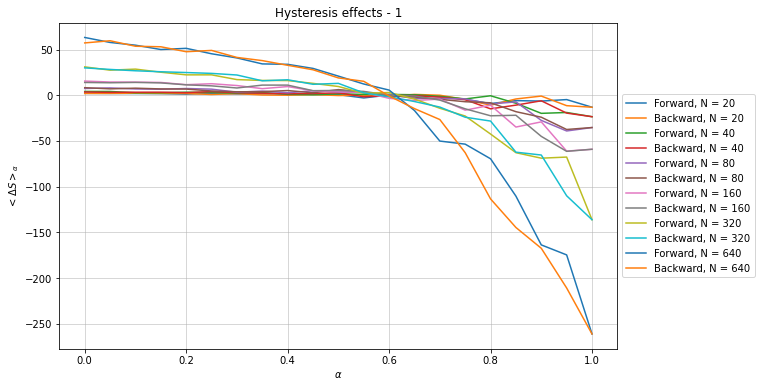

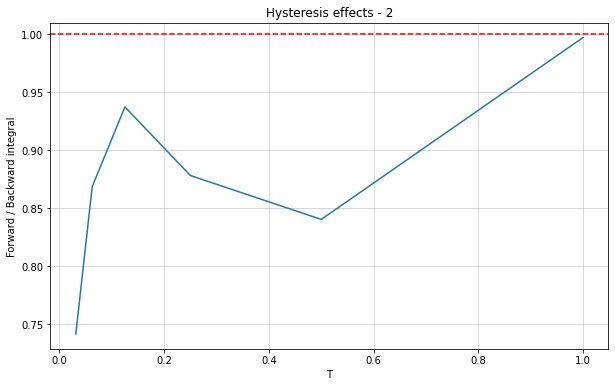

In [93]:
# Mean values plot
fig, ax = plt.subplots(figsize=(10,6))
N0 = N;
for iT in range(n):
    ax.plot(alpha_vec[0:Nswitch+1], mean_deltaS[0:Nswitch+1, iT], label = 'Forward, N = '+str(round(N0)));
    ax.plot(alpha_vec[Nswitch:2*Nswitch+1], mean_deltaS[Nswitch:2*Nswitch+1, iT], label = 'Backward, N = '+str(round(N0)));
    N0 = 2*N0;
    
ax.set_xlabel('$\\alpha$');
ax.set_ylabel('$<\Delta S>_\\alpha$');
plt.grid(linewidth=0.5);
plt.title('Hysteresis effects - 1');
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show();

# Ratio between integrals
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(T_vec, np.abs(integral_dS1 / integral_dS2));
plt.axhline(y = 1, ls = '--', color = 'red')
ax.set_xlabel('T');
ax.set_ylabel('Forward / Backward integral');
plt.grid(linewidth=0.5);
plt.title('Hysteresis effects - 2');
plt.show();

# Hysteresis error estimate (the factor T is included at the end of the code)
err_hyst = np.abs(integral_dS1 - integral_dS2) / 2;

## Exact diagonalization
We repeat the exact diagonalization procedure in order to compare it with the Monte Carlo data.

In [9]:
Ngrid = 800;
xmin = -5;
xmax = 5;

# Potential
xvec = np.linspace(xmin, xmax, Ngrid);     # Vector spanning from xmin to xmax with Ngrid points
Vx = Lambda*(xvec**2-eta**2)**2;

# Kinetic energy discretization
dx = np.diff(xvec).mean();     # Grid resolution
diag = -2*np.ones(Ngrid);      # -2f(x)
offdiag = np.ones(Ngrid-1);    # f(x+dx) and f(x-dx)

d2grid = np.mat(np.diag(diag,0) + np.diag(offdiag,-1) + np.diag(offdiag,1))/dx**2;     # Discretized second derivative

# Avoid problems at the edge of the grid
d2grid[0,:] = 0;
d2grid[Ngrid-1,:] = 0;

Ekin = -hbar**2/(2*m)*d2grid;

# Potential energy discretization
Epot = np.mat(np.diag(Vx, 0))

# Total Hamiltonian diagonalization
H = Ekin + Epot;
w, v = LA.eig(H);

sortinds = np.argsort(w);     # Returns the indices that would sort the array w
EigVals = w[sortinds];        # Eigenvalues sorting
EigVecs = v[:,sortinds];      # Corresponding eigenvectors sorting

### Free energy from exact diagonalization
The free energy can be also computed from exact diagonalization, by using the definition of partition function and the exactly computed eigenvalues:

$$
Z(T) = \sum_n e^{-\beta E_n}
$$

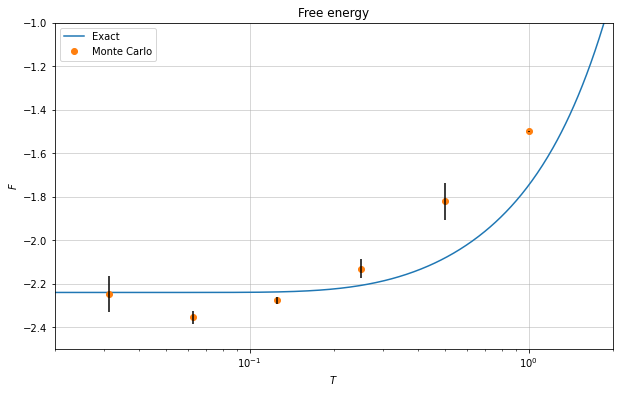

In [99]:
# Bounds
xmin = 0.1;
xmax = 100;
xlogmax = np.log(xmax);
xlogmin = np.log(xmin);
xlog_vec = np.linspace(xlogmin, xlogmax, Ngrid);

F = np.zeros(Ngrid);              # Initialize the free energy
T = np.zeros(Ngrid);              # Initialize the temperature

for il in range(Ngrid):
    xlog = xlog_vec[il];
    xl = np.exp(xlog);
    T[il] = 1/xl;
    Z  = 0;                       # Initialize the partition function
    
    for i in range(Ngrid):                  # Compute the partition function
        Z = Z + np.exp(-EigVals[i]*xl);
    
    F[il] = T[il]*np.log(Z);                # Compute the free energy
    

# Plotting the results
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(T, F, label = 'Exact');
plt.xlim([0.02, 2])
plt.ylim([-2.5, -1])
ax.set_xlabel('$T$');
ax.set_ylabel('$F$');
ax.set_xscale('log');
plt.grid(linewidth=0.5);
plt.title('Free energy');

# Adding Monte Carlo data to the plot
ax.plot(T_vec, F_vec, 'o', label = 'Monte Carlo');
plt.errorbar(T_vec, F_vec, yerr = err_hyst*T_vec, xerr = None, fmt = 'None', ecolor = 'black')
plt.legend();
plt.show()